# Group Proposal - Predicting Following Day Rainfall in Australia


## 1.0 Introduction

#### 1.1 Background

Humans have been looking to the sky for thousands of years in hopes of forecasting the elements. Yet, only after 1869, did humanity begin systematically collecting meteorological data to scientifically predict weather conditions! From the rain's immense impact on various industries, societal infrastructure, and general day-to-day life, predicting its occurrence is pivotal to many facets of society. Particularly, The Australian Bureau of Meteorology has amassed over 10 years of weather data with consistent daily measurements of variables such as wind, humidity, temperature, and most importantly, rain.

#### 1.2 Central Question

Using the data collected in Australia and a classification approach, the research question of our project is:  
**"Will it rain tomorrow in Australia based on a set of meteorological characteristics from the previous day?"**

#### 1.3 Dataset

The dataset that we will use is the “Rain in Australia” dataset by Joe Young and Adam Young. This dataset contains meteorological data across 10 years in Australia from 2007/10/31 to 2017/6/24 in various regions, collected by weather stations across Australia. The dataset contains variables such as weather conditions - wind speed, wind direction and temperature, as well the amount of precipitation in the form of rain on any given day.

## 2.0 Preliminiary Exploratory Data Analysis

#### 2.1 Wrangling

To aid in our decision for predictor variables, we can visualize which columns are present with the most valid data (least NA columns). A larger sample of data would allow us to reduce the impact of factors such as random error in the observation process and improve the overall quality of the analysis. 

In [1]:
#load tidyverse
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#load data into r
url <- "https://raw.githubusercontent.com/Andrewyx/DSCI100-Project-G16/main/weatherAUS.csv"
weather_data_raw <- read_csv(url)

Rows: 145460 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): Location, WindGustDir, WindDir9am, WindDir3pm, RainToday, RainTom...
dbl  (16): MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed,...
date  (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# Summarizes each row by counting non N/A cells. Renames the variables afterwards after conversion to data frame
# This lets us see the variables containing the most amount of usable data, and thus choose our predictors!

no_na_data <- as.data.frame((colSums(!is.na(weather_data_raw)))) 
no_na_data <- cbind(rownames(no_na_data), no_na_data)
rownames(no_na_data) <- NULL
colnames(no_na_data) <- c("measurement","count")

count_tbl <- arrange(no_na_data, desc(count))
count_tbl

measurement,count
<chr>,<dbl>
Date,145460
Location,145460
MaxTemp,144199
MinTemp,143975
WindSpeed9am,143693
Temp9am,143693
Humidity9am,142806
WindSpeed3pm,142398
Rainfall,142199


In [4]:
#Remove categorical variables & variables with too many N/A values (Wrangle Data).

weather_data_clean <- weather_data_raw |>
                            select(-WindGustDir, -WindDir9am, -WindDir3pm, -RainToday, -Date, -Location) |>
                            select(-Sunshine, -Evaporation, -Cloud3pm, -Cloud9am)

In [5]:
# Split training and testing sets

weather_split <- initial_split(weather_data_clean, prop = 0.75, strata = RainTomorrow)
weather_train <- training(weather_split)
weather_test <- testing(weather_split)

#### 2.2 Summarizing Training Data
We now create two summary tables of the training data.  

In [6]:
glimpse(weather_train)

Rows: 109,094
Columns: 13
$ MinTemp       <dbl> 12.9, 9.2, 17.5, 14.6, 7.7, 13.1, 12.6, 9.8, 9.8, 11.5, …
$ MaxTemp       <dbl> 25.7, 28.0, 32.3, 29.7, 26.7, 30.1, 21.0, 27.7, 25.6, 29…
$ Rainfall      <dbl> 0.0, 0.0, 1.0, 0.2, 0.0, 1.4, 3.6, NA, 0.0, 0.0, 0.0, 0.…
$ WindGustSpeed <dbl> 46, 24, 41, 56, 35, 28, 44, 50, 26, 24, 41, 33, 43, 35, …
$ WindSpeed9am  <dbl> 19, 11, 7, 19, 6, 15, 24, NA, 17, 9, 19, 6, 4, 9, 0, 13,…
$ WindSpeed3pm  <dbl> 26, 9, 20, 24, 17, 11, 20, 22, 6, 9, 20, 13, 19, 13, 26,…
$ Humidity9am   <dbl> 38, 45, 82, 55, 48, 58, 65, 50, 45, 56, 54, 55, 49, 45, …
$ Humidity3pm   <dbl> 30, 16, 33, 23, 19, 27, 43, 28, 26, 28, 24, 23, 17, 19, …
$ Pressure9am   <dbl> 1007.6, 1017.6, 1010.8, 1009.2, 1013.4, 1007.0, 1001.2, …
$ Pressure3pm   <dbl> 1008.7, 1012.8, 1006.0, 1005.4, 1010.1, 1005.7, 1001.8, …
$ Temp9am       <dbl> 21.0, 18.1, 17.8, 20.6, 16.3, 20.1, 15.8, 17.3, 15.8, 19…
$ Temp3pm       <dbl> 23.2, 26.5, 29.7, 28.9, 25.5, 28.2, 19.8, 26.2, 23.2, 27…
$ RainTomorrow

#### Means and Missing Rows
The first two summary tables present the means of the predictor variables and the number of rows with missing data.

In [7]:
# Summary table of the mean of predictor variables and rows with missing data

summary_weather_train <- weather_train|>
  summarize(
    Mean_MinTemp = mean(MinTemp, na.rm = TRUE),
    Mean_MaxTemp = mean(MaxTemp, na.rm = TRUE),
    Mean_Rainfall = mean(Rainfall, na.rm = TRUE),
    Mean_WindGustSpeed = mean(WindGustSpeed, na.rm = TRUE),
    Mean_WindSpeed9am = mean(WindSpeed9am, na.rm = TRUE),
    Mean_WindSpeed3pm = mean(WindSpeed3pm, na.rm = TRUE),
    Mean_Humidity9am = mean(Humidity9am, na.rm = TRUE),
    Mean_Humidity3pm = mean(Humidity3pm, na.rm = TRUE),
    Mean_Pressure9am = mean(Pressure9am, na.rm = TRUE),
    Mean_Pressure3pm = mean(Pressure3pm, na.rm = TRUE),
    Mean_Temp9am = mean(Temp9am, na.rm = TRUE),
    Mean_Temp3pm = mean(Temp3pm, na.rm = TRUE))|>
    as.data.frame() |>
    pivot_longer(cols=everything(), names_to="Mean_Categories", values_to="Means")
summary_weather_train

missing_data_table <- tibble(Rows_with_Missing_Data = sum(rowSums(is.na(weather_train)) > 0))
missing_data_table

Mean_Categories,Means
<chr>,<dbl>
Mean_MinTemp,12.193857
Mean_MaxTemp,23.216467
Mean_Rainfall,2.362751
Mean_WindGustSpeed,40.067556
Mean_WindSpeed9am,14.068571
Mean_WindSpeed3pm,18.669216
Mean_Humidity9am,68.896320
Mean_Humidity3pm,51.552495
Mean_Pressure9am,1017.641226


Rows_with_Missing_Data
<int>
19304


#### Available Target Variable Data
The second summary table shows the counts of observations in our target RainTomorrow class.

In [8]:
# Summary table for counts of RainTomorrow observation 

summary_num_obs<-weather_train|>
  group_by(RainTomorrow)|>
  summarize(count=n())
summary_num_obs

RainTomorrow,count
<chr>,<int>
No,82735
Yes,23900
NA,2459


#### 2.3 Visualizing training data

Now we compare the distributions of each of the predictor variables.


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




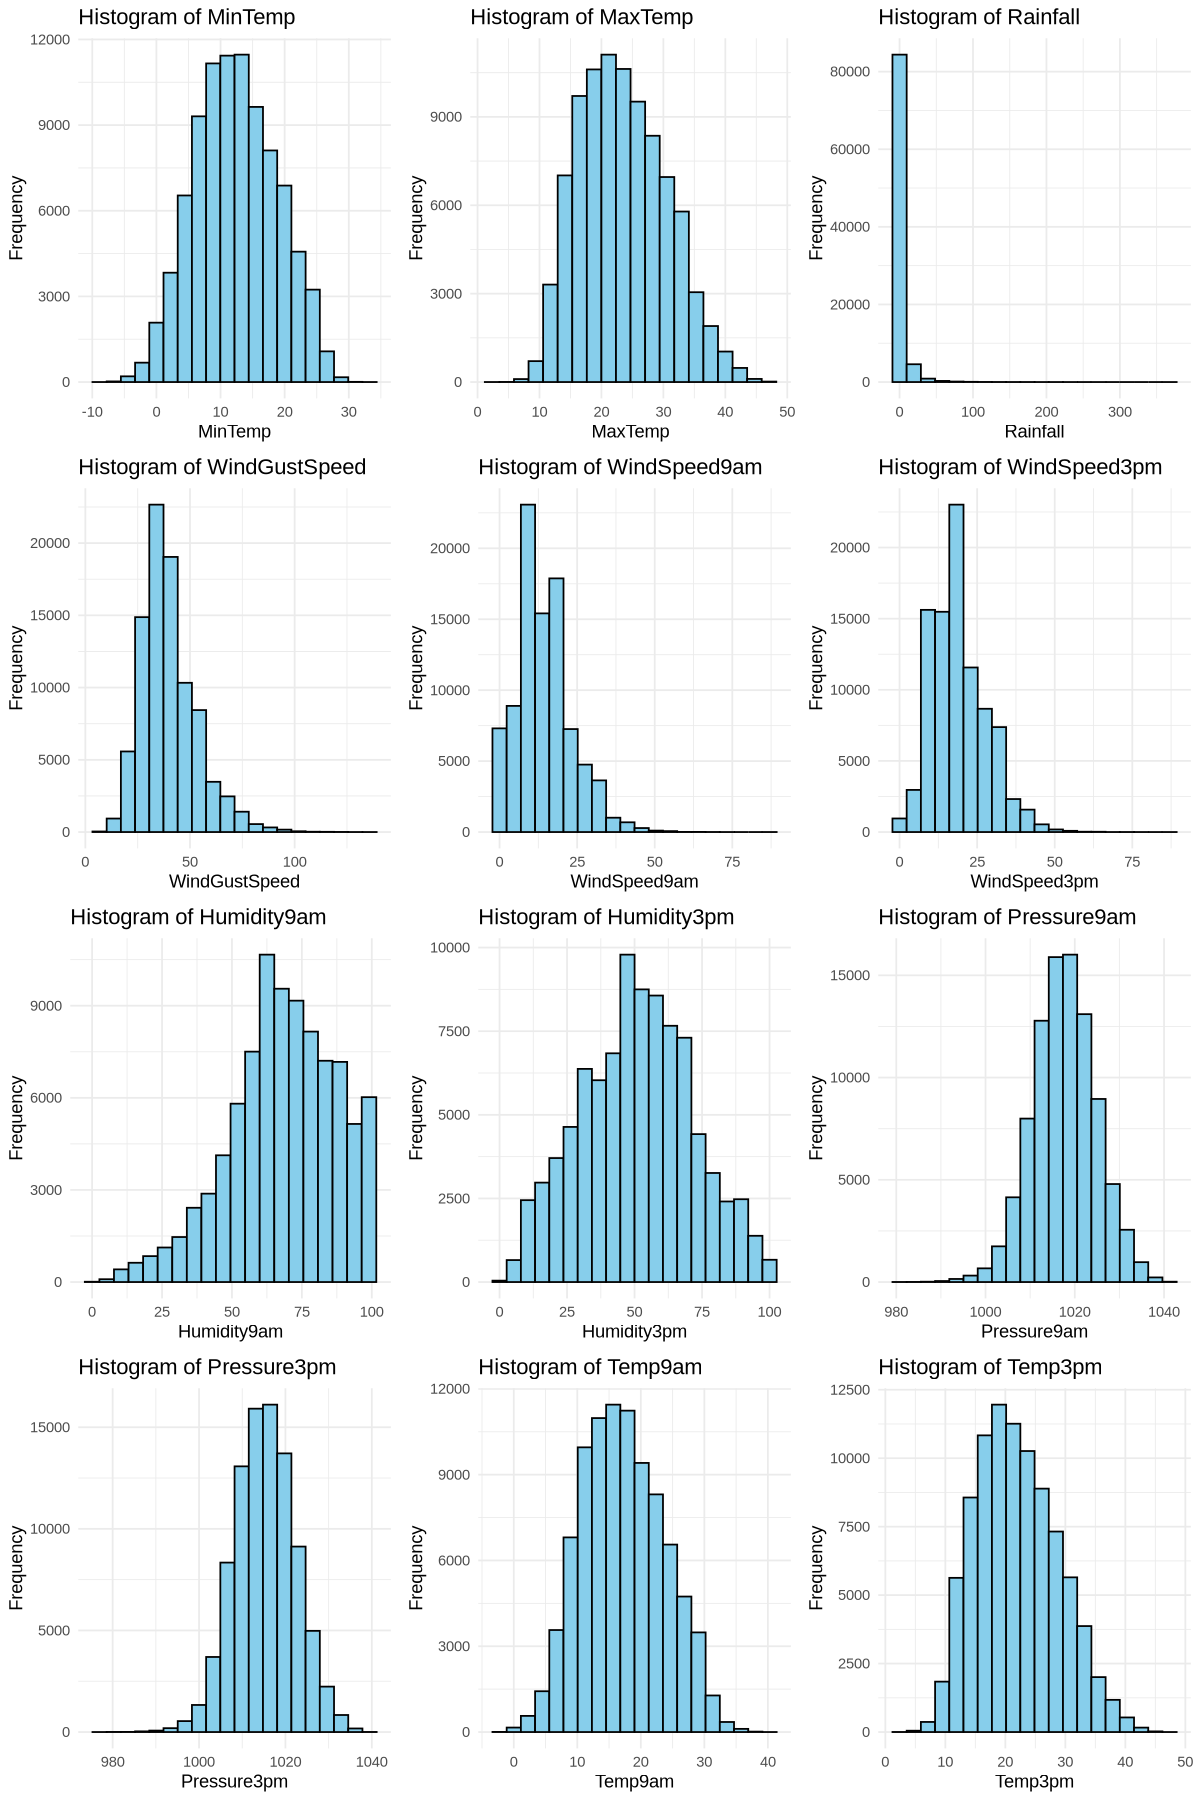

In [9]:
# Visualize distributions of variables via histogram

options(repr.plot.height = 15, repr.plot.width = 10)
library(ggplot2)
library(gridExtra)

weather_predictors <- na.omit(select_if(weather_train, is.numeric))
plots<-lapply(names(weather_predictors), function(col)  {
    ggplot(weather_predictors, aes(x = .data[[col]])) +
      geom_histogram(fill = "skyblue", color = "black",bins=20) +
      labs(title = paste("Histogram of", col),
           x = col, y = "Frequency" ) +
      theme_minimal()
  })
grid.arrange(grobs = plots, ncol = 3)



## 3.0 Methods

#### 3.1 Explain how you will conduct either your data analysis and which variables/columns you will use

The columns we plan to use are those quantifying the day’s weather (numeric variables) with the least number of NA-observation counts. This includes minimum temperature, max temperature, rainfall level, humidity, windspeed and 7 others. This has been proved by listing out the rows containing NA value with the "colSums!(is.na)" function. We have made use of seperate histograms to compare the distributions of each predictor variable and accomodate for their varying range. To note as well, initial splitting by cross-validation has been done for the training results.


#### 3.2 Describe at least one way that you will visualize the results

We will utilize confusion matrices as the main way to visualize our final results since we plan on using 12 predictor variables. This will allow us to better decide whether we should tune our model for precision or recall for further possible analysis. 

## 4.0 Expected Outcomes and Significance:

#### 4.1 Expected Outcomes

We are anticipating a model that can predict with a `Yes` or `No` response whether there is rain the next day in Australia, using a specific set of weather characteristics as input. We expect that our classification model will be able to predict this result based on learning correlations within the data and without simply memorizing data points. 

#### 4.2 Significance of Investigation

The significance of this analysis lies in the immense impact that weather and in particular, rain, has on society. Being able to predict rain is not only beneficial for day-to-day life but quintessential for industries such as agriculture, tourism, and urban development

#### 4.3 Extended/Further Questions

Investigating precipitation further in the future can prompt inquiries on how rain patterns have evolved throughout the last decade. Furthermore, this investigation can also prompt further analysis into how accurate our model can be when compared to modern circumstances (ie, how can we better tune our model for precision or recall instead?).